<a href="https://colab.research.google.com/github/vicmcl/ml-laptime/blob/main/ml_laptime/notebook/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from pathlib import Path
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [29]:
# Mount Drive
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive')
DRIVE_PATH = Path("/content/drive/MyDrive/")
ML_PATH = DRIVE_PATH / "Projects" / "laptime-simulation"

Mounted at /content/drive


In [30]:
data_path = glob.glob(str(ML_PATH / "races_*.pkl"))

In [31]:
pip install -q fastf1

In [32]:
data_path

['/content/drive/MyDrive/Projects/laptime-simulation/races_2021.pkl',
 '/content/drive/MyDrive/Projects/laptime-simulation/races_2020.pkl',
 '/content/drive/MyDrive/Projects/laptime-simulation/races_2019.pkl']

In [40]:
data = {}

for path in data_path:
    with open(path, "rb") as f:
        data[int(path.split(".")[0][-4:])] = pickle.load(f)

In [6]:
columns_laps = [
    'Time', 'LapNumber', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
    'Compound', 'TyreLife', 'LapTime', 'PitOutTime', 'PitInTime'
]

columns_telemetry = ['SessionTime', 'Throttle', 'Brake', 'DRS']

columns_weather = ['Time', 'TrackTemp', 'WindSpeed']

compound_map = {
    'SOFT': 1.0,
    'MEDIUM': 2.0,
    'HARD': 3.0
}

In [42]:
data[2021]['Abu Dhabi Grand Prix']['status']

,Time,Status,Message
0,0 days 00:00:00,1,AllClear
1,0 days 01:40:06.247000,2,Yellow
2,0 days 01:40:47.317000,1,AllClear
3,0 days 01:55:03.019000,6,VSCDeployed
4,0 days 01:57:53.608000,7,VSCEnding
5,0 days 01:58:06.176000,1,AllClear
6,0 days 02:20:38.379000,2,Yellow
7,0 days 02:20:54.313000,4,SCDeployed
8,0 days 02:31:02.298000,1,AllClear


In [71]:
def process_track_status(gp, year):
    track_status = data[year][gp]['status'].copy()
    track_status['Incident'] = track_status['Status'].map(lambda s: False if s == '1' else True)
    mask = track_status['Incident'] & track_status['Incident'].shift(1)
    track_status = track_status[~mask][['Time', 'Incident']]
    track_status['Time'] = track_status['Time'].map(lambda x: x.total_seconds())
    return track_status

In [72]:
status = process_track_status('Abu Dhabi Grand Prix', 2021)
status

,Time,Incident
0,0.000,False
1,6006.247,True
2,6047.317,False
3,6903.019,True
5,7086.176,False
6,8438.379,True
8,9062.298,False


In [7]:
def process_lap_data(gp, year):
    laps_data = data[year][gp]['laps'][columns_laps].copy()
    laps_data['Season'] = year
    laps_data = laps_data.reset_index().drop('index', axis=1)
    laps_data['Compound'] = laps_data['Compound'].map(lambda x: compound_map.get(x, 0.0))
    mask = pd.isnull(laps_data['PitOutTime']) | pd.isnull(laps_data['PitInTime'])
    laps_data = laps_data[mask]
    laps_data = laps_data.drop(['PitOutTime', 'PitInTime'], axis=1)
    return laps_data

In [8]:
def map_drs(drs):
    if drs >= 10:
        return True
    else:
        return False

def process_telemetry_data(gp, year, laps):
    telemetry_data = data[year][gp]['telemetry'][columns_telemetry].copy()
    telemetry_with_laps = pd.merge_asof(
        telemetry_data,
        laps[['Time', 'LapNumber']],
        left_on='SessionTime',
        right_on='Time',
        direction='forward'
    ).drop('Time', axis=1)
    telemetry_with_laps.loc[:, 'DRS'] = telemetry_with_laps['DRS'].map(map_drs)
    telemetry_avg = telemetry_with_laps.groupby('LapNumber').mean()
    return telemetry_avg

In [9]:
def process_weather_data(gp, year):
    weather_data = data[year][gp]['weather'][columns_weather].copy()
    return weather_data

In [10]:
def merge_data(laps, weather, telemetry):
    merged_data = pd.merge_asof(laps, weather, on='Time', direction='nearest').set_index('LapNumber').drop('Time', axis=1)
    merged_data = pd.concat([merged_data, telemetry], axis=1).reset_index()
    merged_data = merged_data.drop('SessionTime', axis=1)
    merged_data.loc[:, 'LapTime'] = merged_data['LapTime'].map(lambda x: x.total_seconds())
    return merged_data

In [11]:
def preprocess_data(gp, year):
    laps = process_lap_data(gp, year)
    weather = process_weather_data(gp, year)
    telemetry = process_telemetry_data(gp, year, laps)
    merged_data = merge_data(laps, weather, telemetry)
    return merged_data

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

si = SimpleImputer()

In [22]:
gp = 'Spanish Grand Prix'
df = pd.DataFrame()

for year in sorted(list(data.keys())):
    laps = process_lap_data(gp, year)
    weather = process_weather_data(gp, year)
    telemetry = process_telemetry_data(gp, year, laps)
    merged_data = merge_data(laps, weather, telemetry)
    for col in merged_data.columns:
        merged_data[col] = si.fit_transform(merged_data[[col]])
    df = pd.concat([df, merged_data])

df = df.reset_index(drop=True)
df = df.dropna(subset='LapTime')

df['LagLapTime'] = df['LapTime'].shift(1)
df['RollingMeanLapTime'] = df['LapTime'].rolling(window=5).mean()

In [23]:
df.info()

<class 'fastf1.core.Laps'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LapNumber           198 non-null    float64
 1   Stint               198 non-null    float64
 2   SpeedI1             198 non-null    float64
 3   SpeedI2             198 non-null    float64
 4   SpeedFL             198 non-null    float64
 5   SpeedST             198 non-null    float64
 6   Compound            198 non-null    float64
 7   TyreLife            198 non-null    float64
 8   LapTime             198 non-null    float64
 9   Season              198 non-null    float64
 10  TrackTemp           198 non-null    float64
 11  WindSpeed           198 non-null    float64
 12  Throttle            198 non-null    float64
 13  Brake               198 non-null    float64
 14  DRS                 198 non-null    float64
 15  LagLapTime          197 non-null    float64
 16  RollingMeanLapTime 

In [24]:
df.head()

,LapNumber,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Compound,TyreLife,LapTime,Season,TrackTemp,WindSpeed,Throttle,Brake,DRS,LagLapTime,RollingMeanLapTime
0,1.0,1.0,268.000000,248.0,275.0,283.0,1.0,4.0,87.210892,2019.0,41.8,1.5,60.328869,0.193452,0.0,NaN,NaN
1,2.0,1.0,267.000000,251.0,275.0,306.0,1.0,5.0,83.595000,2019.0,42.0,1.6,61.998403,0.185304,0.0,87.210892,NaN
2,3.0,1.0,258.945455,264.0,275.0,307.0,1.0,6.0,83.359000,2019.0,41.8,3.0,62.625000,0.179487,0.0,83.595000,NaN
3,4.0,1.0,258.945455,260.0,276.0,306.0,1.0,7.0,83.097000,2019.0,41.8,2.2,63.937299,0.183280,0.0,83.359000,NaN
4,5.0,1.0,269.000000,259.0,276.0,308.0,1.0,8.0,82.803000,2019.0,41.3,2.7,63.308562,0.180937,0.0,83.097000,84.012978


In [25]:
laps_to_predict = 5
remaining_laps = 20

df_train, df_test = df.iloc[:-remaining_laps], df.iloc[-remaining_laps:-remaining_laps + laps_to_predict]

In [26]:
df_train[df_train[]

,LapNumber,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Compound,TyreLife,LapTime,Season,TrackTemp,WindSpeed,Throttle,Brake,DRS,LagLapTime,RollingMeanLapTime
0,1.0,1.0,268.0,248.0,275.0,283.0,1.0,4.0,87.210892,2019.0,41.8,1.5,60.328869,0.193452,0.0,NaN,NaN
66,1.0,1.0,260.0,244.0,272.0,283.0,1.0,4.0,83.724754,2020.0,50.1,2.3,61.027632,0.194737,0.0,80.449,80.929751
132,1.0,1.0,264.0,266.0,270.0,274.0,1.0,4.0,86.190000,2021.0,31.7,0.1,64.739708,0.171315,0.0,83.629,83.287200


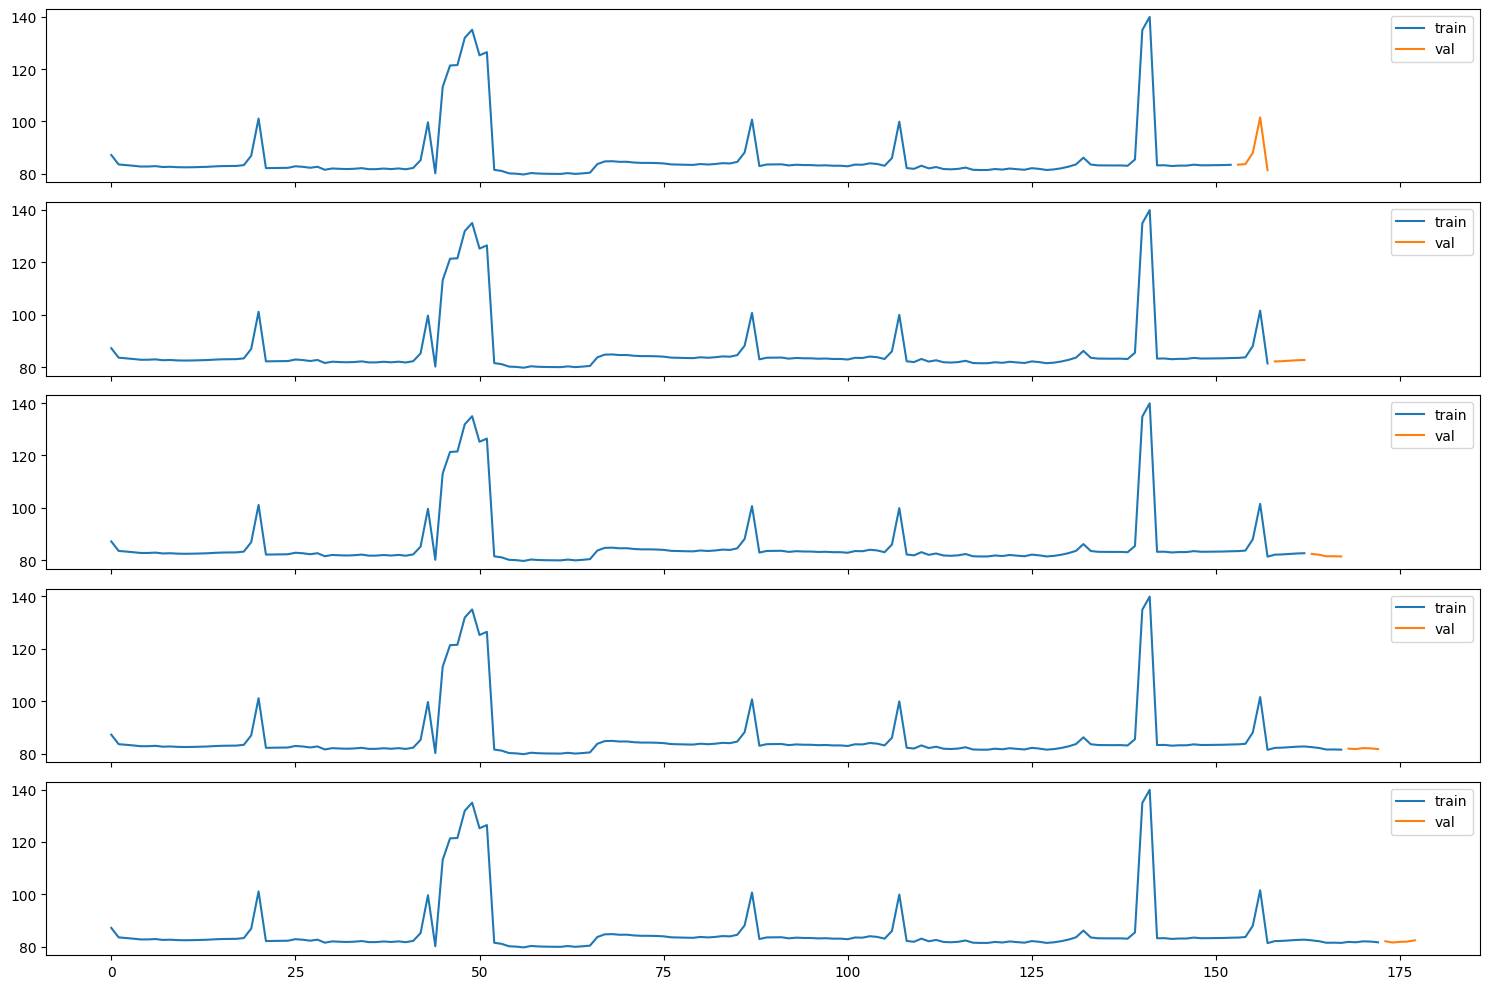

In [27]:
from sklearn.model_selection import TimeSeriesSplit

n_splits = 5
tss = TimeSeriesSplit(n_splits=n_splits, test_size=5)

fig, axs = plt.subplots(n_splits, 1, figsize=(15, 10), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df_train):
    train = df_train.loc[train_idx]
    val = df_train.loc[val_idx]
    train['LapTime'].plot(ax=axs[fold], label='train')
    val['LapTime'].plot(ax=axs[fold], label='val')
    axs[fold].legend()
    fold += 1
plt.tight_layout()
plt.show()

In [ ]:
def select_speed_trap(data):
    corr = data[['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']].corr()
    speed_trap = corr['LapTime'].iloc[1:].abs().idxmax()
    return speed_trap

def filter_speed_trap(data, speed_trap):
    data = data.drop([speed for speed in ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST'] if speed != speed_trap], axis=1)
    data = data.rename(columns={speed_trap: 'SpeedTrap'})
    return data

In [ ]:
for train_idx, val_idx in tss.split(df_train):
    break

speed_trap = select_speed_trap(df_train.loc[train_idx])

df_train = filter_speed_trap(df_train, speed_trap)
df_test = filter_speed_trap(df_test, speed_trap)

In [ ]:
FEATURES = list(df_train.columns)
FEATURES.remove('LapTime')
TARGET = 'LapTime'

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

preds = []
scores = []

for train_idx, val_idx in tss.split(df_train):
    X_train, y_train = df_train.loc[train_idx, FEATURES], df_train.loc[train_idx, TARGET]
    X_val, y_val = df_train.loc[val_idx, FEATURES], df_train.loc[val_idx, TARGET]

    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        early_stopping_rounds=50,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )

    y_pred = model.predict(X_val)
    preds.append(y_pred)
    score = mean_squared_error(y_val, y_pred, squared=False)
    scores.append(score)

[0]	validation_0-rmse:1.62069
[100]	validation_0-rmse:0.57272
[200]	validation_0-rmse:0.20168
[300]	validation_0-rmse:0.12385
[377]	validation_0-rmse:0.12496
[0]	validation_0-rmse:1.76676
[100]	validation_0-rmse:0.81631
[200]	validation_0-rmse:0.52427
[298]	validation_0-rmse:0.49604
[0]	validation_0-rmse:1.52874
[100]	validation_0-rmse:0.49094
[200]	validation_0-rmse:0.12300
[300]	validation_0-rmse:0.09270
[311]	validation_0-rmse:0.09632
[0]	validation_0-rmse:8.45354
[100]	validation_0-rmse:4.27411
[200]	validation_0-rmse:2.39815
[300]	validation_0-rmse:1.86425
[400]	validation_0-rmse:1.83690
[500]	validation_0-rmse:1.80301
[600]	validation_0-rmse:1.77515
[700]	validation_0-rmse:1.74808
[800]	validation_0-rmse:1.72682
[900]	validation_0-rmse:1.71502
[999]	validation_0-rmse:1.69960
[0]	validation_0-rmse:2.39411
[100]	validation_0-rmse:1.06911
[200]	validation_0-rmse:0.62177
[300]	validation_0-rmse:0.48403
[400]	validation_0-rmse:0.42519
[500]	validation_0-rmse:0.40855
[600]	validation_0

In [ ]:
import numpy as np

print('Score across folds:', np.mean(scores))

Score across folds: 0.6529649226134514


In [ ]:
X_train = df_train[FEATURES]
y_train = df_train[TARGET]

model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    verbose=100
)

[0]	validation_0-rmse:8.48334
[100]	validation_0-rmse:4.26419
[200]	validation_0-rmse:2.43500
[300]	validation_0-rmse:1.44554
[400]	validation_0-rmse:0.87234
[500]	validation_0-rmse:0.53268
[600]	validation_0-rmse:0.32910
[700]	validation_0-rmse:0.20754
[800]	validation_0-rmse:0.13674
[900]	validation_0-rmse:0.09623
[999]	validation_0-rmse:0.07228


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
df_test['Preds'] = model.predict(df_test[FEATURES])

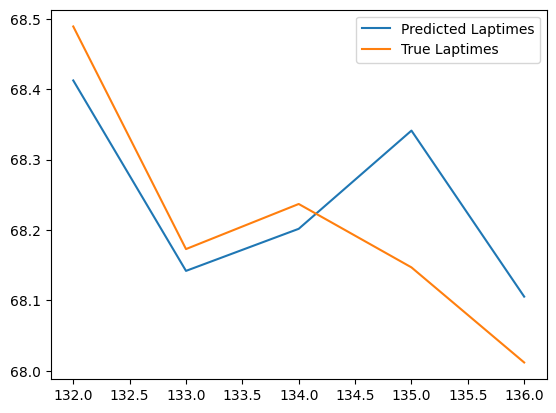

In [ ]:
df_test['Preds'].plot(label="Predicted Laptimes")
df_test['LapTime'].plot(label="True Laptimes")
plt.legend()
plt.show()

In [ ]:
score_test = mean_squared_error(df_test['LapTime'], df_test['Preds'], squared=False)
print('Test Score:', score_test)

Test Score: 0.10441907577375033
